# Homework 1 Solutions
## FINM 36700 - 2023

Tobias Rodriguez del Pozo
tobiasdelpozo@uchicago.edu

### HBS Case
#### *Smart Beta Exchange-Traded Funds and Factor Investing*

# 1

## 1.1

- Size Factor (Small minus Big -- SMB). Small cap minus big cap. Split stocks into 5 quantiles, long smallest quantile and short largest quantile (by market cap).
- Value Factor (High minus Low -- HML). High book-to-market ratio minus low book-to-market ratio. Split stocks into 5 quantiles, long highest quantile and short lowest quantile (by book-to-market ratio).
- Quality Factor (Robust minus Weak -- RMW). Robust operating profitability minus weak operating profitability. Split stocks into 5 quantiles, long highest quantile and short lowest quantile (by operating profitability).
- Investment Factor (Conservative minus Aggressive -- CMA). Conservative investment minus aggressive investment. Split stocks into 5 quantiles, long lowest quantile and short lowest highest (by investment).
- Momentum (Up minus Down -- UMD). Up minus down. Split stocks into 5 quantiles, long highest quantile and short lowest quantile (by returns in previous year).

## 1.2

Long-short.

## 1.3

They do this by picking distinct metrics, and also going long-short, in order to control for the MKT variable. This combined with distinct metrics allows them to isolate the effect of the factor whilst maintaining low correlations to the other factors.

## 1.4

Showing the difference in returns between the highest and lowest quantiles for the factors.

## 1.5

From Page 9 of the case. Smart beta ETFs are a combination of passive and active investing. Whereas a passive ETF tracks an index, and is almost always long-only, a smart beta ETF will track a factor index, and will thus be long-short. This is compared to just market cap weighted ETFs (passive).

## 1.6

No. From Page 9:

"For every value investor, who tilds towards or selects cheap value stocks, there must be an investor on the other side who is underweighting value and overweighting expensive, growth stocks. Hence as everything must add up to the market-weighted portfolio, everyone at once cannot hold or tild towards value at the same time."

## 1.7

We aren't doing MV-optimization. Rather, we are specifically trying to target a factor, not just maximize Sharpe. For example, if we look at page 13, we see that the weighting scheme used by Research Affiliates gives weights proportional to the value of the financial variable.

# 2

## 2.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

pd.options.display.float_format = '{:,.4f}'.format

sys.path.append('../cmds/')

import TA_utils as ta

plt.style.use('ggplot')

from functools import partial
read_excel = partial(pd.read_excel, index_col=0, parse_dates=[0], io='../data/factor_pricing_data.xlsx')

factors = read_excel(sheet_name='factors (excess returns)')
portfolios = read_excel(sheet_name='portfolios (excess returns)')

In [2]:
full_sample = ta.calc_performance_metrics(factors).iloc[:, :3]
full_sample

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.0846,0.1573,0.5376
SMB,0.0112,0.1005,0.1115
HML,0.0253,0.1102,0.2299
RMW,0.0465,0.0834,0.5578
CMA,0.0325,0.0734,0.4428
UMD,0.0609,0.1555,0.3918


## 2.2

Yes, all have positive risk premia.

,Annualized Return Pre,Annualized Volatility Pre,Annualized Sharpe Ratio Pre,Annualized Return Post,Annualized Volatility Post,Annualized Sharpe Ratio Post
MKT,0.0779,0.1561,0.4992,0.1117,0.1627,0.6865
SMB,0.0160,0.1011,0.1583,-0.0084,0.0983,-0.0852
HML,0.0379,0.1028,0.3685,-0.0258,0.1358,-0.1901
RMW,0.0460,0.0858,0.5362,0.0486,0.0731,0.6645
CMA,0.0400,0.0696,0.5751,0.0018,0.0870,0.0206
UMD,0.0743,0.1581,0.4697,0.0065,0.1440,0.0451


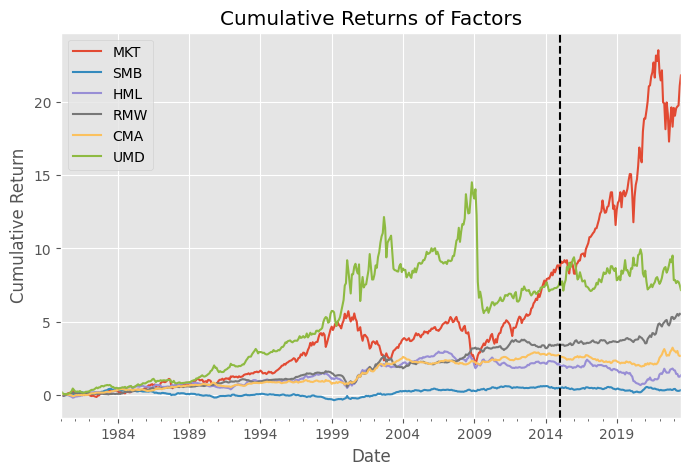

In [3]:
pre_case = ta.calc_performance_metrics(factors.loc[:'2014']).iloc[:, :3]
post_case = ta.calc_performance_metrics(factors.loc['2015':]).iloc[:, :3]

pre_post = pre_case.join(post_case, lsuffix=' Pre', rsuffix=' Post')
display(pre_post)

# Plot cumulative returns of factors, add vertical line at 2015
fig, ax = plt.subplots(figsize=(8, 5))
cum_rets = (1 + factors).cumprod() - 1
cum_rets.plot(ax=ax)
ax.axvline('2015', color='k', linestyle='--')
ax.set_title('Cumulative Returns of Factors')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date');

MKT has done by far the best, and has been soaring up compared to the other factors, especially after the case. UMD has stayed around flat after the case, although it did well before the case. SMB and HML go from positive expected returns to negative.

Overall, all of the factors except MKT and RML do worse after the case than before the case.

## 2.3

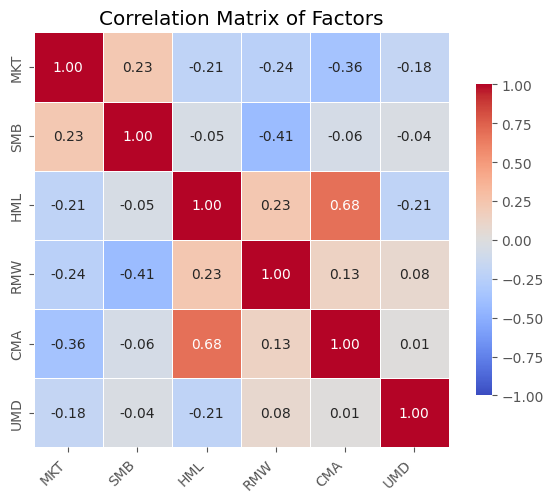

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = ta.plot_correlation_matrix(factors.corr(), ax=ax)
ax.set_title('Correlation Matrix of Factors')
fig.tight_layout()

a.

With the exception of HML and CMA, which has a correlation of 0.68, all of the factors have quite low correlations. Moreover, a lot of them have negative correlations, which is interesting. RMW and SMB also have a -0.41 correlation, which is somewhat high.

b.

I would say so. Given the high correlation HML has to CMA and moderate correlation is has to RMW then it is likely that HML is picking up on something similar to CMA. So, out of all of the factors, it could be the most redundant.

## 2.4

In [5]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns,columns=['Weight'])

w_tan = tangency_weights(factors)
w_tan.join(full_sample).sort_values('Annualized Return', ascending=False)

,Weight,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.2039,0.0846,0.1573,0.5376
UMD,0.0938,0.0609,0.1555,0.3918
RMW,0.3074,0.0465,0.0834,0.5578
CMA,0.3693,0.0325,0.0734,0.4428
HML,-0.0618,0.0253,0.1102,0.2299
SMB,0.0874,0.0112,0.1005,0.1115


a.

CMA and RMW have the highest weights, incidating that they are the most important. HML and SMB have the lowest weights, indicating that they are the least important.

b.

Yes, note that CMA and RMW have the highest weights, but definitely do not have the highest mean returns. Both MKT and UMD have better mean returns, but lower weights. This again goes back to the fact that when doing MV-optimization, we are not just looking at mean returns, but also covariances.

c.

In [6]:
factors_sub = factors[['MKT', 'SMB', 'HML', 'UMD']]

w_tan_sub = tangency_weights(factors_sub)
w_tan_sub

,Weight
MKT,0.3564
SMB,-0.0062
HML,0.3489
UMD,0.3009


Now MKT, HML, and UMB all have roughly equal and high weights, and SMB has virtually 0 weight. SO, I would conclude that SMB is probably not super important, and that MKT, HML, and UMB are all important.

# 3

## 3.1

a.

In [7]:
from collections import defaultdict
from itertools import product
import statsmodels.api as sm

summary = defaultdict(list)
capm = sm.add_constant(factors['MKT'])
aqr = sm.add_constant(factors[['MKT', 'HML', 'RMW', 'UMD']])
ff3 = sm.add_constant(factors[['MKT', 'SMB', 'HML']])
ff5 = sm.add_constant(factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']])

col_names = product(['CAPM', 'AQR', 'FF3', 'FF5'], ['Alpha', 'R^2'])
col_names = list(map(lambda x: ' '.join(x), col_names))

summary = pd.DataFrame(0, index=portfolios.columns, columns=col_names)

models = [*zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5])]

for asset in portfolios.columns:
    asset_ret = portfolios[asset]
    for name, X in models:
        model = sm.OLS(asset_ret, X).fit()
        summary.loc[asset, f'{name} Alpha'] = model.params[0]
        summary.loc[asset, f'{name} R^2'] = model.rsquared
        

summary[['AQR Alpha', 'AQR R^2']]

,AQR Alpha,AQR R^2
Agric,0.0008,0.3413
Food,0.0010,0.4711
Soda,0.0016,0.3072
Beer,0.0020,0.4267
Smoke,0.0029,0.2726
Toys,-0.0027,0.5103
Fun,0.0026,0.6173
Books,-0.0025,0.6897
Hshld,-0.0005,0.5603
Clths,-0.0010,0.6318


b.

In [8]:
summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12

,MAE
CAPM Alpha,0.0206
AQR Alpha,0.0230
FF3 Alpha,0.0242
FF5 Alpha,0.0313


They are all pretty big, around 2\% annualized. The biggest one is for the FF5, and the lowest is for the vanilla CAPM. 

This does not support the pricing model. We could also run a t-test to see if the difference is statistically significant.

## 3.3

It's hard to say. All of the models perform worse than the CAPM, so in some sense the only important factor is MKT. However, AQR performs second best, which further indicates that HML or CMA are redundant and should not be used. Yes, Fama and French should probably add the momentum factor to their model.

## 3.4

In [9]:
summary.loc[:, ~summary.columns.str.contains('Alpha')].mean().to_frame('R^2')

,R^2
CAPM R^2,0.5281
AQR R^2,0.5771
FF3 R^2,0.5725
FF5 R^2,0.5975


Not particularly. They only explain about 50-60% of the variation. This indicates moderately low explainability of excess returns by decomposition on different factor models. Thus the factors may not be considered good in a Linear Factor Decomposition of the assets.

## 3.5

a.

In [10]:
def calc_pricing_regression(rets, factors, intercept=True, adj=12):
    if intercept:
        factors = sm.add_constant(factors)
    summary = {f'{k} Beta': [] for k in factors.columns[1:]}
    summary['Alpha']  = []
    summary['R^2']    = []
    for asset in rets.columns:
        model = sm.OLS(rets[asset], factors).fit()
        for k, _ in summary.items():
            try:
                summary[k].append(model.params[k[:-5]])
            except:
                pass
        summary['R^2'].append(model.rsquared)
        summary['Alpha'].append(model.params[0] * adj)
            
    return pd.DataFrame(summary, index=rets.columns)

def calc_cross_sectional_regression(mean_rets, betas, intercept=False):
    if intercept:
        betas = sm.add_constant(betas)
    model = sm.OLS(mean_rets, betas).fit()
    params = model.params.to_frame('Cross Sectional Regression')
    params.loc['R^2'] = model.rsquared
    params.loc['MAE'] = model.resid.abs().mean() 
    return params

frames = []

ts_premia = portfolios.mean() * 12

for name, X in zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5]):
    pricing_regr = calc_pricing_regression(portfolios, X, intercept=False)
    res = calc_cross_sectional_regression(ts_premia, pricing_regr.iloc[:, :-2], intercept=False)
    res = res.rename({'Cross Sectional Regression': f'{name} CS'}, axis=1)
    frames.append(res)

summary_cs = pd.concat(frames, axis=1).fillna('')

# Move R^2 and MAE to the top
summary_cs = pd.concat([summary_cs.loc[['R^2', 'MAE']], summary_cs.drop(['R^2', 'MAE'])])
summary_cs_betas = summary_cs[summary_cs.index.str.contains('Beta')].copy()
summary_cs_betas.loc[:, 'Time Series'] = factors.mean().values * 12
summary_cs_betas

,CAPM CS,AQR CS,FF3 CS,FF5 CS,Time Series
MKT Beta,0.0857,0.0876,0.1016,0.0957,0.0846
HML Beta,,-0.0398,-0.0175,-0.0335,0.0112
RMW Beta,,0.0444,,0.0359,0.0253
UMD Beta,,0.0534,,,0.0465
SMB Beta,,,-0.0646,-0.0577,0.0325
CMA Beta,,,,-0.0152,0.0609


For MKT, they don't differ that much. Likewise, for UMD and RMW, there isn't a huge difference. However, for SMB, HML, and CMA, there is a big difference, where a lot of the estimated premia are negative!

b.

In [11]:
import warnings
warnings.filterwarnings('ignore')

alpha_mae = summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12

cs_mae = summary_cs.loc[['MAE']].T

# Append it row-wise
mae = alpha_mae.append(cs_mae)
mae

,MAE
CAPM Alpha,0.0206
AQR Alpha,0.0230
FF3 Alpha,0.0242
FF5 Alpha,0.0313
CAPM CS,0.0207
AQR CS,0.0164
FF3 CS,0.0150
FF5 CS,0.0130


They are for the most part smaller than the time-series MAE, with the notable exception of CAPM, which is very slightly higher.